### Create LangChain Documents from Different Documents

In [1]:
# Read in State of the Union Address File
with open("../RAG_Docs/2024_state_of_the_union.txt") as f:
    state_of_the_union = f.read()

# Read in Mangione CBS News Article
with open("../RAG_Docs/2024_12_10_Mangione_CBS_Article.txt") as f:
    mangione_cbs_article = f.read()

In [2]:
# Imports
from langchain_text_splitters import CharacterTextSplitter

# Initialize Text Splitter
text_splitter = CharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

# Create Documents (Chunks) From File
state_of_the_union_texts = text_splitter.create_documents([state_of_the_union])
mangione_cbs_article_texts = text_splitter.create_documents([mangione_cbs_article])

# OUTPUT
print('====State of the Union====')
print(f'LEN: {len(state_of_the_union_texts)}')
if len(state_of_the_union_texts) > 0:
    print(f'TYPE: {type(state_of_the_union_texts[0])}')
    print(f'{state_of_the_union_texts[0]}\n\n')

print('====Mangione CSB Article====')
print(f'LEN: {len(mangione_cbs_article_texts)}')
if len(mangione_cbs_article_texts) > 0:
    print(f'TYPE: {type(mangione_cbs_article_texts[0])}')
    print(f'{mangione_cbs_article_texts[0]}\n\n')

====State of the Union====
LEN: 48
TYPE: <class 'langchain_core.documents.base.Document'>
page_content='March 07, 2024
Remarks of President Joe Biden — State of the Union Address As Prepared for Delivery
Home
Briefing Room
Speeches and Remarks
The United States Capitol

###

Good evening. 

Mr. Speaker. Madam Vice President. Members of Congress. My Fellow Americans. 

In January 1941, President Franklin Roosevelt came to this chamber to speak to the nation. 

He said, “I address you at a moment unprecedented in the history of the Union.” 

Hitler was on the march. War was raging in Europe. 

President Roosevelt’s purpose was to wake up the Congress and alert the American people that this was no ordinary moment.   

Freedom and democracy were under assault in the world. 

Tonight I come to the same chamber to address the nation. 

Now it is we who face an unprecedented moment in the history of the Union. 

And yes, my purpose tonight is to both wake up this Congress, and alert the Ameri

In [3]:
# Add MetaData For Filter By FileName

# 2024_state_of_the_union.txt
for i, doc in enumerate(state_of_the_union_texts):
    doc.metadata = {
        'filename': '2024_state_of_the_union.txt',
        'chunk': i + 1
    }

# 2024_12_10_Mangione_CBS_Article.txt
for i, doc in enumerate(mangione_cbs_article_texts):
    doc.metadata = {
        'filename': '2024_12_10_Mangione_CBS_Article.txt',
        'chunk': i + 1
    }

# OUTPUT
print('====State of the Union====')
if len(state_of_the_union_texts) > 0:
    print(f'{state_of_the_union_texts[0].metadata}\n\n')

print('====Mangione CSB Article====')
if len(mangione_cbs_article_texts) > 0:
    print(f'{mangione_cbs_article_texts[0].metadata}\n\n')

====State of the Union====
{'filename': '2024_state_of_the_union.txt', 'chunk': 1}


====Mangione CSB Article====
{'filename': '2024_12_10_Mangione_CBS_Article.txt', 'chunk': 1}




### Populate Local ChromaDB Instance With Chunked Documents

In [4]:
# Create ChromaDB Vector Store

# Imports
import chromadb
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os
from langchain_chroma import Chroma

# Load Env Variables
load_dotenv('../.env')

# Create Client
chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection("test_collection")

# Set Up Embeddings Model
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Set Up ChromaDB As Vector Store
vector_store = Chroma(
    client=chroma_client,
    collection_name="test_collection",
    embedding_function=embeddings,
)

In [5]:
# Add Documents to Vector Store

# Concatenate Docs List
documents = state_of_the_union_texts + mangione_cbs_article_texts

# Add Documents to Vector Store
ids = vector_store.add_documents(documents)

In [6]:
# TEST SIMILARITY SEARCH
test_search_result = vector_store.similarity_search(
    "Who is Luigi Magione?",
    k=3
)

for i, item in enumerate(test_search_result):
    chunk = item.metadata['chunk']
    filename = item.metadata['filename']
    
    print(f'====DOCUMENT {i}====')
    print(f'FILENAME: {filename}')
    print(f'CHUNK {chunk}')
    print(item.page_content + '\n\n')

====DOCUMENT 0====
FILENAME: 2024_12_10_Mangione_CBS_Article.txt
CHUNK 14
Mangione's paternal grandparents, Nicholas and Mary Mangione, were real estate developers who purchased the Turf Valley Country Club in 1978 and Hayfields Country Club in Hunt Valley in 1986. 

They founded Lorien Health Systems in 1977, and operated WCBM, a Baltimore radio station. Luigi Mangione volunteered at Lorien Health Systems in 2014 while in high school, according to his LinkedIn.

Mangione's family said Monday in a statement, "Unfortunately, we cannot comment on news reports regarding Luigi Mangione. We only know what we have read in the media. Our family is shocked and devastated by Luigi's arrest. We offer our prayers to the family of Brian Thompson and we ask people to pray for all involved. We are devastated by this news."

### He was valedictorian at the Gilman School in Baltimore


====DOCUMENT 1====
FILENAME: 2024_12_10_Mangione_CBS_Article.txt
CHUNK 1
# What we know about Luigi Mangione, suspect

In [7]:
# FILTER SEARCH BY FILE NAME
vector_store.get(where={'filename': "2024_12_10_Mangione_CBS_Article.txt"})['documents']

["# What we know about Luigi Mangione, suspect charged in UnitedHealthcare CEO's killing\n\nBy Alex Sundby, Layla Ferris, Laura Doan, Emma Li, John Doyle\nUpdated on: December 10, 2024 / 8:36 PM EST / CBS News\n\nLuigi Mangione has been charged with murder in last week's deadly shooting of UnitedHealthcare CEO Brian Thompson, according to court documents filed Monday night. The 26-year-old, who was identified earlier as a person of interest, was arrested on firearms and other charges in Pennsylvania after being spotted at a McDonald's in Altoona amid a massive manhunt for the shooter.\n\n### Here's what we know about Mangione:\n\nLuigi Mangione identified as suspect in CEO shooting\nPolice said Tuesday it appears Mangione went to Pittsburgh and then Altoona after leaving New York and that he was dodging surveillance using a signal-blocking bag.",
 '"You can put your phone in there so we can\'t track your phone," Joseph Kenny, chief of detectives for the New York City Police Department,

### Agentic LLM Tools

In [8]:
# Tools
from typing import List

def get_file_list() -> List[str]:
    """Retrieves a list of file names, as strings, that are currently available in the database and accessible to the user. Use this tool to get the files that the user can summarize. ONLY run this tool if the user specifically asks to summarize a file.
    
    Args:
        None
    """
    return ['2024_state_of_the_union.txt', '2024_12_10_Mangione_CBS_Article.txt']

def get_file_content_by_name(filename: str) -> str:
    """Retrieves and summarizes the content of the specified document.
    
    Args:
        filename: A string which is the name of the file to retrieve the content for.
    """
    
    # Check if it is a vaild file
    valid_files = ['2024_state_of_the_union.txt', '2024_12_10_Mangione_CBS_Article.txt']
    if (filename not in valid_files):
        return "ERROR: NOT A VALID FILE NAME... TRY AGAIN..."
    
    # Get the Contents from the Vector DB
    content_list = vector_store.get(where={'filename': filename})['documents']
    content = "\n".join(content_list)
    
    return content

def default_rag(query: str) -> str:
    """Searches the vector database for relevant chunks of information based on the query.
    
    Args:
        query: the user's query that will be used to return similar content chunks.
    """
    results = vector_store.similarity_search(
        query,
        k=3
    )
    content_list = [f"* {res.page_content} [{res.metadata}]" for res in results]
    content = "\n".join(content_list)
    return content

In [9]:
# Bind Tools To LLM

# Imports
from langchain_openai import ChatOpenAI

# Initialize the LLM instance
llm = ChatOpenAI(model="gpt-4o-mini")

# Get Tools
tools = [get_file_list, get_file_content_by_name, default_rag]

# Bind Tools to LLM
llm_with_tools = llm.bind_tools(tools)

### Create the Reasoner Node's Functionality

In [10]:
# Imports
from langchain_core.messages import HumanMessage, SystemMessage

# Create Reasoner Function
def reasoner(state):
    
    # Get Query + Messages from Graph State
    query = state["query"]
    messages = state["messages"]
    
    # System Message
    sys_msg = "You are a helpful AI Agent Assistant. You Check tools and decide which tool to use based on the user's query. They can either summarize a single file or search across all files for the RAG profile. Based on that context returned, you will answer the query to the best of your ability."
    
    # Update Messages
    message = HumanMessage(query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages": result}

### Create the LangGraph

In [11]:
# Create Graph State
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    query: str
    messages: Annotated[list[AnyMessage], add_messages]

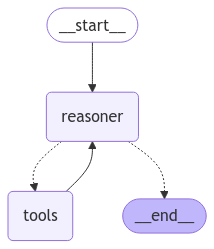

In [12]:
# Create Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

# Graph State
workflow = StateGraph(State)

# Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools))

# Edges
workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition
)
workflow.add_edge("tools", "reasoner")

# Compile Graph
reAct_graph = workflow.compile()

# Display Graph
from IPython.display import Image, display
display(Image(reAct_graph.get_graph(xray=True).draw_mermaid_png()))

### Article Summarization Workflow

In [13]:
response = reAct_graph.invoke({
    "query": "Summarize the article about Luigi Mangione.",
    "messages": []
})

In [14]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Summarize the article about Luigi Mangione.
================================== Ai Message ==================================
Tool Calls:
  get_file_list (call_BpveEyBsyB19QlxgIGQUVRf4)
 Call ID: call_BpveEyBsyB19QlxgIGQUVRf4
  Args:
================================= Tool Message =================================
Name: get_file_list

["2024_state_of_the_union.txt", "2024_12_10_Mangione_CBS_Article.txt"]
================================ Human Message =================================

Summarize the article about Luigi Mangione.
================================== Ai Message ==================================
Tool Calls:
  get_file_content_by_name (call_trTQvT2M9KLGAceAZImSLKeo)
 Call ID: call_trTQvT2M9KLGAceAZImSLKeo
  Args:
    filename: 2024_12_10_Mangione_CBS_Article.txt
================================= Tool Message =================================
Name: get_file_content_by_name

# What we know about Lu

### Regular RAG Flow

In [15]:
rag_response = reAct_graph.invoke({
    "query": "Who was the CEO of United Healthcare that was killed?",
    "messages": []
})

In [16]:
for m in rag_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Who was the CEO of United Healthcare that was killed?
================================== Ai Message ==================================
Tool Calls:
  default_rag (call_LWuYcmNuGNT8TBFeiyU1zCPt)
 Call ID: call_LWuYcmNuGNT8TBFeiyU1zCPt
  Args:
    query: CEO of United Healthcare killed
================================= Tool Message =================================
Name: default_rag

* # What we know about Luigi Mangione, suspect charged in UnitedHealthcare CEO's killing

By Alex Sundby, Layla Ferris, Laura Doan, Emma Li, John Doyle
Updated on: December 10, 2024 / 8:36 PM EST / CBS News

Luigi Mangione has been charged with murder in last week's deadly shooting of UnitedHealthcare CEO Brian Thompson, according to court documents filed Monday night. The 26-year-old, who was identified earlier as a person of interest, was arrested on firearms and other charges in Pennsylvania after being spotted at a McDonald'